## Variant 2 (Markov Switching)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

from pypfopt import black_litterman, plotting
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### Data Collection

In [7]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "RIVN", "INTC", "AMD"]

start_date = '2014-01-01'
end_date = '2024-01-01'

# market data
market_data = yf.download("VOO", start=start_date, end=end_date)
market_data['Returns'] = np.log(market_data['Close'] / market_data['Close'].shift(1))  # Log returns
market_returns = market_data['Returns']
market_data = market_data.dropna()
market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]

# ticker data
ticker_data = yf.download(tickers, start=start_date, end=end_date)
closing_prices = ticker_data["Adj Close"]
ticker_returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_capitalisation(tickers):
    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)

    return market_caps

market_data.tail(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  7 of 7 completed


,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2023-12-15,433.190002,434.250000,432.239990,433.089996,425.711884,5281900,-0.001523
2023-12-18,434.640015,436.399994,434.450012,435.540009,428.120178,4280500,0.005641
2023-12-19,436.040009,438.220001,435.950012,438.190002,430.725037,4061500,0.006066
2023-12-20,435.510010,437.309998,429.899994,430.089996,424.507751,5783200,-0.018658
2023-12-21,433.130005,434.640015,430.859985,434.279999,428.643402,4621600,0.009695
2023-12-22,435.459991,436.839996,433.480011,435.290009,429.640320,4035200,0.002323
2023-12-26,435.670013,437.920013,435.579987,437.100006,431.426819,3835800,0.004150
2023-12-27,436.899994,438.019989,436.420013,437.899994,432.216431,4271000,0.001829
2023-12-28,438.250000,438.839996,437.660004,437.970001,432.285492,4703700,0.000160


In [54]:
closing_prices.tail(10)

Ticker,AMD,AMZN,INTC,META,NVDA,RIVN,TSLA
Date,,,,,,,
2023-12-15 00:00:00+00:00,139.149994,149.970001,45.549957,333.645477,48.876141,22.830000,253.500000
2023-12-18 00:00:00+00:00,138.899994,154.070007,45.086163,343.308594,50.062805,23.799999,252.080002
2023-12-19 00:00:00+00:00,140.149994,153.789993,46.043350,349.026733,49.589939,24.350000,257.220001
2023-12-20 00:00:00+00:00,135.470001,152.119995,45.155243,347.950867,48.097359,23.180000,247.139999
2023-12-21 00:00:00+00:00,139.910004,153.839996,46.457802,352.742523,48.976116,23.580000,254.500000
2023-12-22 00:00:00+00:00,139.600006,153.419998,47.365639,352.045197,48.816162,23.209999,252.539993
2023-12-26 00:00:00+00:00,143.410004,153.410004,49.832600,353.479675,49.265030,23.590000,256.609985
2023-12-27 00:00:00+00:00,146.070007,153.339996,50.089161,356.468323,49.402992,23.730000,261.440002
2023-12-28 00:00:00+00:00,148.759995,153.380005,49.724056,356.956482,49.507965,23.540001,253.179993


### Market Logarithmic Returns

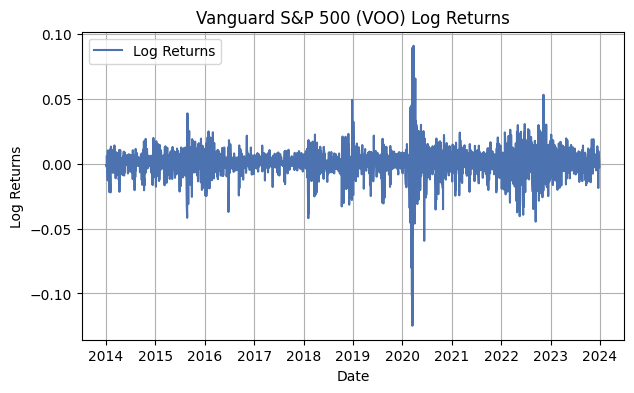

In [8]:
def plot_log_returns(market_data):
    plt.figure(figsize=(7,4))
    plt.plot(market_data.index, market_data['Returns'], label='Log Returns')
    plt.title('Vanguard S&P 500 (VOO) Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

plot_log_returns(market_data)

### Fit Markov-Switching Model

In [9]:
def fit_markov_switching(market_data):
    model = MarkovRegression(market_data['Returns'], k_regimes=2, switching_variance=True)
    results = model.fit()
    return results

results = fit_markov_switching(market_data)
results.summary()

c:\Users\Chantal.Maskell\Documents\Projects\Black_Litterman_Portfolio_Optimisation\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                 2515
Model:               MarkovRegression   Log Likelihood                8309.822
Date:                Thu, 02 Jan 2025   AIC                         -16607.643
Time:                        15:58:17   BIC                         -16572.663
Sample:                             0   HQIC                        -16594.948
                               - 2515                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      7.206      0.000       0.001       0.001
sigma2      3.184e-05   1.82e-06     17.523      0.000    2.83e-05    3.54e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.597      0.110      -0.002       0.000
sigma2         0.0003   1.73e-05     17.259      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9773      0.005    198.022      0.000       0.968       0.987
p[1->0]        0.0435      0.009      4.715      0.000       0.025       0.062
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### Get Regime Probabilities

In [10]:
# smoothed probs for each regime
smoothed_probs_regime_0 = results.smoothed_marginal_probabilities[0]
smoothed_probs_regime_1 = results.smoothed_marginal_probabilities[1]

# transition probabilities matrix
transition_probs = results.params[-4:]  # last 4 parameters are usually transition probabilities

# regimes for each observation
predicted_regimes = results.predicted_marginal_probabilities.idxmax(axis=1)

# other fitted parameters
means = results.params[:2]  # mean for regime 0 and mean for regime 1
variances = results.params[2:4]  # variances for regime 0 and regime 1

print("Smoothed probabilities for Regime 0:\n", smoothed_probs_regime_0)
print("Smoothed probabilities for Regime 1:\n", smoothed_probs_regime_1)
print("Transition probabilities:\n", transition_probs)
print("Predicted regimes:\n", predicted_regimes)
print("Means of each regime:", means)
print("Variances of each regime:", variances)

Smoothed probabilities for Regime 0:
 Date
2014-01-03    0.985658
2014-01-06    0.992799
2014-01-07    0.995220
2014-01-08    0.995805
2014-01-09    0.993361
                ...   
2023-12-22    0.940632
2023-12-26    0.972330
2023-12-27    0.982840
2023-12-28    0.983633
2023-12-29    0.976061
Name: 0, Length: 2515, dtype: float64
Smoothed probabilities for Regime 1:
 Date
2014-01-03    0.014342
2014-01-06    0.007201
2014-01-07    0.004780
2014-01-08    0.004195
2014-01-09    0.006639
                ...   
2023-12-22    0.059368
2023-12-26    0.027670
2023-12-27    0.017160
2023-12-28    0.016367
2023-12-29    0.023939
Name: 1, Length: 2515, dtype: float64
Transition probabilities:
 const[0]     0.001090
const[1]    -0.000955
sigma2[0]    0.000032
sigma2[1]    0.000298
dtype: float64
Predicted regimes:
 Date
2014-01-03    0
2014-01-06    0
2014-01-07    0
2014-01-08    0
2014-01-09    0
             ..
2023-12-22    1
2023-12-26    0
2023-12-27    0
2023-12-28    0
2023-12-29    0
L

### Define View Confidences

In [11]:
markov_relative_views = np.array([0.20, 0.15, 0.10, -0.07]).reshape(-1, 1)

def set_view_confidences_for_views(results, markov_relative_views, threshold_bull=0.6, threshold_bear=0.4):
    smoothed_probs = results.smoothed_marginal_probabilities
    
    view_confidences = []
    
    # check views matches a valid range
    if len(markov_relative_views) > len(smoothed_probs[0]):
        raise ValueError("Number of views exceeds the number of time steps in smoothed probabilities.")
    
    # iterate over views and assign confidences
    for idx in range(len(markov_relative_views)):
        bull_prob = smoothed_probs[0][idx]
        bear_prob = smoothed_probs[1][idx]
        
        if bull_prob > threshold_bull:
            confidence = bull_prob
        elif bear_prob > threshold_bear:
            confidence = bear_prob
        else:
            confidence = max(bull_prob, bear_prob)
        
        view_confidences.append(confidence)
    
    return view_confidences

markov_adjusted_confidences = set_view_confidences_for_views(results, markov_relative_views, threshold_bull=0.6, threshold_bear=0.4)
markov_adjusted_confidences

C:\Users\Chantal.Maskell\AppData\Local\Temp\ipykernel_18516\1362896055.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bull_prob = smoothed_probs[0][idx]
C:\Users\Chantal.Maskell\AppData\Local\Temp\ipykernel_18516\1362896055.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bear_prob = smoothed_probs[1][idx]


[0.9856577708877108,
 0.9927987974322122,
 0.9952199459918101,
 0.9958046276131647]

### Filter Regime Returns

In [12]:
def filter_returns_by_regime(results, market_data):
    smoothed_probs = results.smoothed_marginal_probabilities

    if not isinstance(smoothed_probs, pd.DataFrame):
        smoothed_probs = pd.DataFrame(smoothed_probs)

    # assign most likely regime to each time step
    market_data['Regime'] = smoothed_probs.idxmax(axis=1)

    # filter returns by regime
    regime_returns = {
        regime: market_data[market_data['Regime'] == regime]['Returns']
        for regime in range(smoothed_probs.shape[1])
    }

    # cov matrix for each regime
    covariance_matrices = {
        regime: market_data[market_data['Regime'] == regime].cov()
        for regime in range(smoothed_probs.shape[1])
    }

    return regime_returns, covariance_matrices

regime_returns, covariance_matrices = filter_returns_by_regime(results, market_data)

for regime, cov_matrix in covariance_matrices.items():
    print(f"Regime {regime} covariance matrix:\n{cov_matrix}\n")

Regime 0 covariance matrix:
                   Open          High           Low         Close  \
Open       6.569677e+03  6.600072e+03  6.540462e+03  6.574969e+03   
High       6.600072e+03  6.631404e+03  6.571073e+03  6.606322e+03   
Low        6.540462e+03  6.571073e+03  6.512287e+03  6.546673e+03   
Close      6.574969e+03  6.606322e+03  6.546673e+03  6.582092e+03   
Adj Close  7.017763e+03  7.051554e+03  6.987250e+03  7.025355e+03   
Volume     7.148381e+07  7.193072e+07  7.091291e+07  7.145755e+07   
Returns    1.274563e-02  1.541520e-02  1.563195e-02  1.816561e-02   
Regime     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              Adj Close        Volume     Returns  Regime  
Open       7.017763e+03  7.148381e+07    0.012746     0.0  
High       7.051554e+03  7.193072e+07    0.015415     0.0  
Low        6.987250e+03  7.091291e+07    0.015632     0.0  
Close      7.025355e+03  7.145755e+07    0.018166     0.0  
Adj Close  7.508561e+03  7.657415e+07    0.018974 

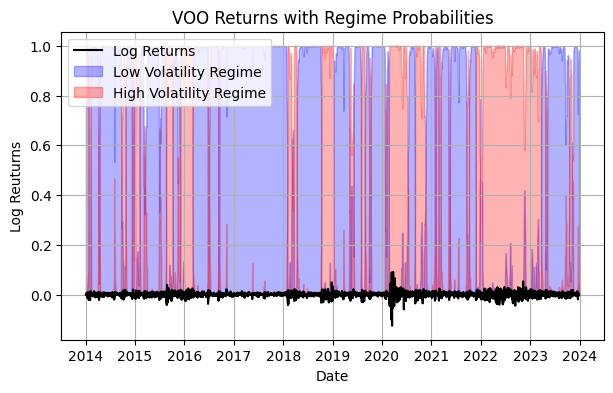

In [13]:
# To visalise when the market is in bull/bear periods. 
# can see the likelihood of each one occuring using smoothed probabilities
def plot_regime_probabilities(market_data):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(market_data. index, market_data['Returns'], label='Log Returns', color='black')
    
    ax.fill_between(market_data.index, 0, results.smoothed_marginal_probabilities[0], color='blue', alpha=0.3, label='Low Volatility Regime')
    ax.fill_between(market_data.index, 0, results.smoothed_marginal_probabilities[1], color='red', alpha=0.3, label='High Volatility Regime') # Any red sections show the market in high volatility period

    ax.set_title('VOO Returns with Regime Probabilities')
    ax.set_xlabel('Date')
    ax.set_ylabel("Log Reuturns")
    plt.grid()
    ax.legend(loc='upper left')
    plt.show()

plot_regime_probabilities(market_data)

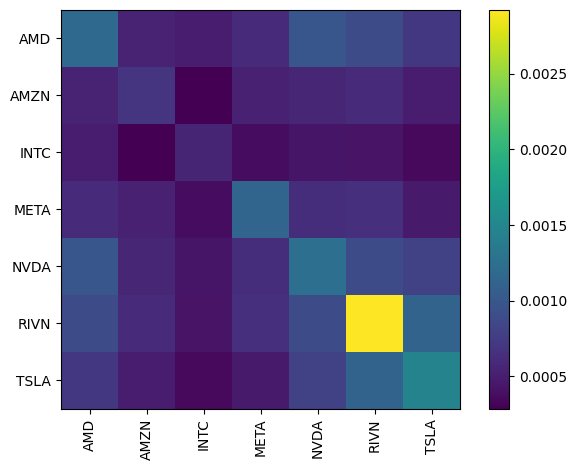

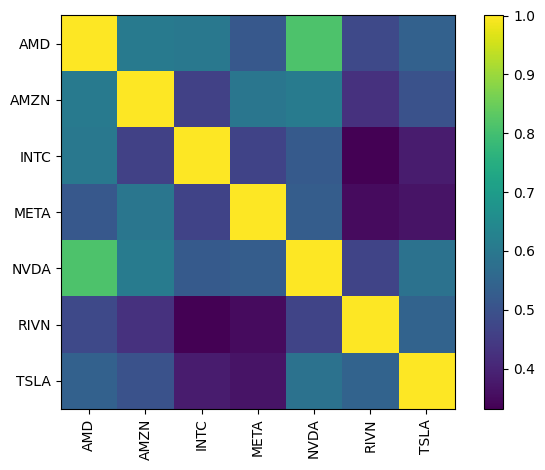

In [14]:
markov_covariance_matrix = ticker_returns.cov()

covariance_plot = plotting.plot_covariance(markov_covariance_matrix, plot_correlation=False)
correlation_plot = plotting.plot_covariance(markov_covariance_matrix, plot_correlation=True)

### Get Prior and Delta

In [15]:
market_caps = get_market_capitalisation(tickers)

markov_delta = black_litterman.market_implied_risk_aversion(market_prices)
markov_prior = black_litterman.market_implied_prior_returns(market_caps, markov_delta, markov_covariance_matrix)

markov_prior

Ticker
AMD     0.022673
AMZN    0.022029
INTC    0.021314
META    0.022342
NVDA    0.023086
RIVN    0.022815
TSLA    0.022613
dtype: float64

### Define Investor Views

In [16]:
picking_matrix = np.array([
    [1, 0, -1, 0, 0, 0, 0],  # TSLA - AMZN
    [0, 1, 0, -1, 0, 0, 0],  # NVDA - META
    [0, 0, 0, 1, 0, 0, -1],  # META - AMD
    [0, 0, 0, 0, 0, -1, 1]   # INTC - AMD
])

### Run Black Litterman Model

In [17]:
markov_bl = BlackLittermanModel(
    markov_covariance_matrix,
    pi=markov_prior,
    absolute_views=None,
    Q=markov_relative_views,
    P=picking_matrix,
    omega="idzorek",
    view_confidences=markov_adjusted_confidences,
    tau=0.025, 
    risk_aversion=markov_delta
)

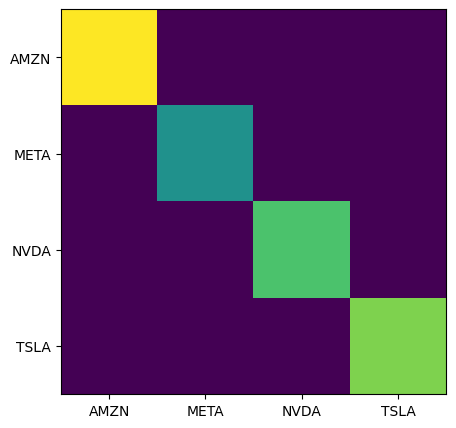

In [18]:
def plot_omega():
    tickers_with_views = ["AMZN", "META", "NVDA", "TSLA"]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(markov_bl.omega)

    ax.set_xticks(np.arange(len(tickers_with_views)))
    ax.set_yticks(np.arange(len(tickers_with_views)))

    ax.set_xticklabels(tickers_with_views)
    ax.set_yticklabels(tickers_with_views)
    plt.show()

    np.diag(markov_bl.omega)

plot_omega()

### Calculate Posterior Returns

In [19]:
markov_bl_returns = markov_bl.bl_returns()
markov_bl_returns

Ticker
AMD     0.168768
AMZN    0.158229
INTC   -0.028079
META    0.010315
NVDA    0.115475
RIVN   -0.017593
TSLA   -0.087821
dtype: float64

In [65]:
markov_relative_views_series = pd.Series(np.nan, index=tickers)
markov_relative_views_series[:len(markov_relative_views)] = markov_relative_views.flatten()

markov_returns_df = pd.DataFrame([markov_prior, markov_bl_returns, pd.Series(markov_relative_views_series)], index=["Prior", "Posterior", "Views"]).T
markov_returns_df

,Prior,Posterior,Views
AMD,0.022672,0.168767,NaN
AMZN,0.022029,0.158229,0.10
INTC,0.021314,-0.028079,NaN
META,0.022338,0.010316,-0.07
NVDA,0.023084,0.115473,0.15
RIVN,0.022818,-0.017592,NaN
TSLA,0.022621,-0.087820,0.20


<Axes: >

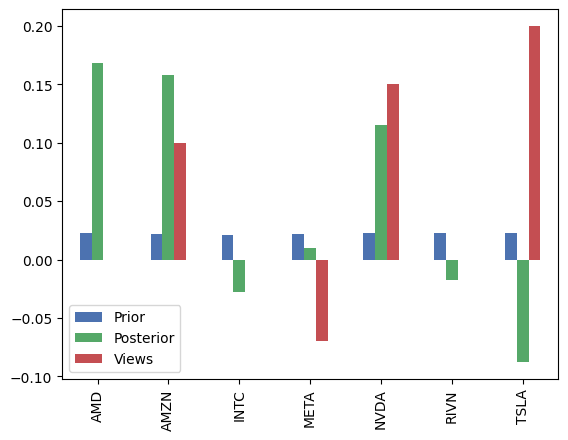

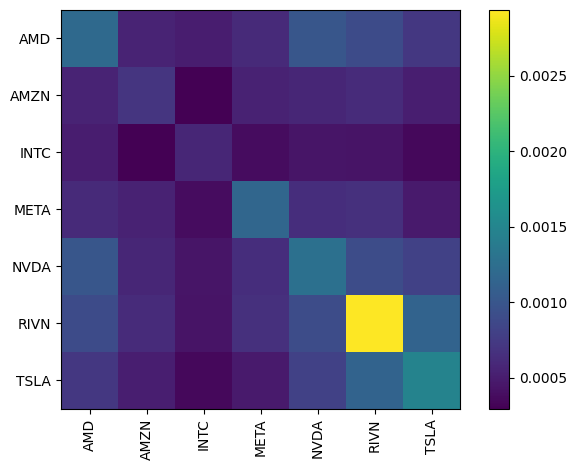

In [72]:
# visualisation of above
markov_returns_df.plot.bar()

posterior_cov = markov_bl.bl_cov()
plotting.plot_covariance(posterior_cov)

<Axes: >

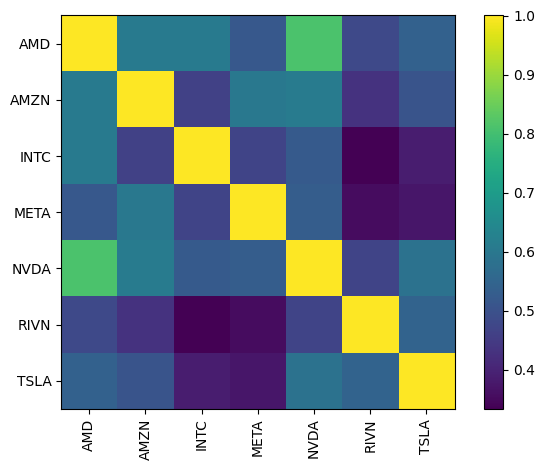

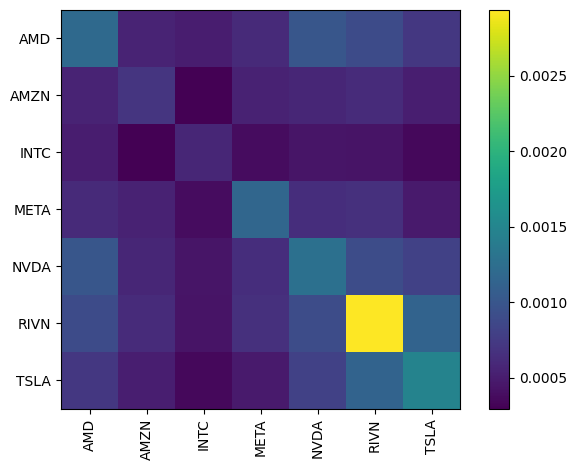

In [20]:
posterior_cov = markov_bl.bl_cov()
plotting.plot_covariance(posterior_cov, plot_correlation=True)
plotting.plot_covariance(posterior_cov, plot_correlation=False)

### Efficient Frontier Weights

#### Minimum Volatility

In [21]:
ef_1 = EfficientFrontier(markov_bl_returns, posterior_cov)
min_vol_weights = ef_1.min_volatility()
cleaned_weights_min_vol = ef_1.clean_weights()

cleaned_weights_min_vol

OrderedDict([('AMD', 0.0),
             ('AMZN', 0.37654),
             ('INTC', 0.57175),
             ('META', 0.01482),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.0369)])

#### Max Sharpe

In [22]:
ef_2 = EfficientFrontier(markov_bl_returns, posterior_cov)
max_sharpe_weights = ef_2.max_sharpe()
cleaned_weights_max_sharpe = ef_2.clean_weights()

cleaned_weights_max_sharpe

OrderedDict([('AMD', 0.24931),
             ('AMZN', 0.75069),
             ('INTC', 0.0),
             ('META', 0.0),
             ('NVDA', 0.0),
             ('RIVN', 0.0),
             ('TSLA', 0.0)])

### Plot Asset Allocation Pies

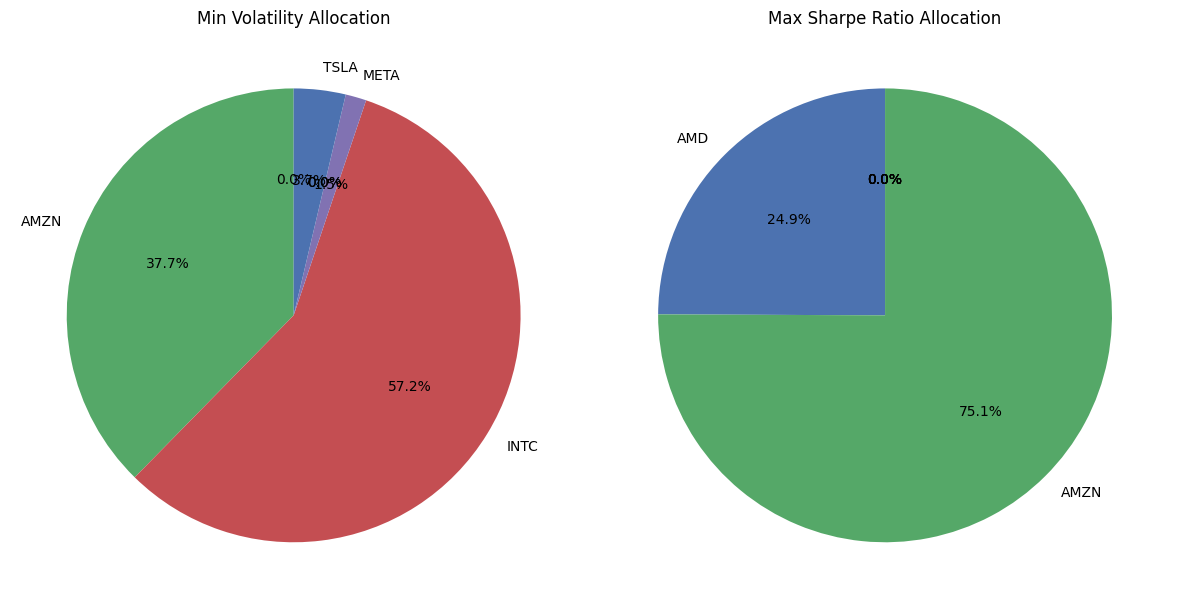

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Minimum Volaility
pd.Series(cleaned_weights_min_vol).plot.pie(
    ax=axes[0], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Min Volatility Allocation"
)

# Plot Max Sharpe
pd.Series(cleaned_weights_max_sharpe).plot.pie(
    ax=axes[1], 
    autopct='%1.1f%%', 
    startangle=90, 
    title="Max Sharpe Ratio Allocation"
)

plt.tight_layout()
plt.show()

### Portfolio Performance

#### Minimum Volatility Performance

In [24]:
ef_1.portfolio_performance(verbose=True)

Expected annual return: 4.0%
Annual volatility: 2.1%
Sharpe Ratio: 0.95


(0.04043817435962828, 0.021425738640229175, 0.9539075736345147)

#### Max Sharpe Performance

In [25]:
ef_2.portfolio_performance(verbose=True)

Expected annual return: 16.1%
Annual volatility: 2.6%
Sharpe Ratio: 5.41


(0.16085633575442895, 0.026020260110528923, 5.413333116429239)

### Get Discrete Allocation (DA)

#### Minimum Volatility DA

In [26]:
latest_prices = get_latest_prices(closing_prices)
da_min_vol = DiscreteAllocation(cleaned_weights_min_vol, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_min_vol.lp_portfolio(verbose=True)

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

Funds remaining: 2.16
AMD: allocated 0.000, desired 0.000
AMZN: allocated 0.380, desired 0.377
INTC: allocated 0.570, desired 0.572
META: allocated 0.000, desired 0.015
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.000, desired 0.000
TSLA: allocated 0.050, desired 0.037
Allocation has RMSE: 0.008
{'AMZN': 25, 'INTC': 115, 'TSLA': 2}


#### Max Sharpe DA

In [27]:
latest_prices = get_latest_prices(closing_prices)
da_max_sharpe = DiscreteAllocation(cleaned_weights_max_sharpe, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_max_sharpe.lp_portfolio(verbose=True)

#  quantities of shares that should be bought to have a 10,000£ portfolio
print(allocation)

Funds remaining: 25.51
AMD: allocated 0.251, desired 0.249
AMZN: allocated 0.746, desired 0.751
INTC: allocated 0.000, desired 0.000
META: allocated 0.000, desired 0.000
NVDA: allocated 0.000, desired 0.000
RIVN: allocated 0.002, desired 0.000
TSLA: allocated 0.000, desired 0.000
Allocation has RMSE: 0.002
{'AMD': 17, 'AMZN': 49, 'RIVN': 1}
